In [1]:
import numpy as np
import datetime as dt
import os
import pandas as pd
import math
import scipy
import requests
import warnings
import json
import h5py
from pyproj import Proj, CRS
import pysolid
import matplotlib.pyplot as plt
import rasterio as rio
from isce3.core import Ellipsoid as ellips
warnings.filterwarnings('ignore')
import h5py
from src.ALE_utils import oversample_slc, findCR, interpolate_correction_layers



# 0. Read OPERA Coregistered SLC

In [2]:
# Parameters for papermill
wdir = '/u/trappist-r0/bato/work/ROSAMOND/provisional_data'

burst_id = 't064_135518_iw1'
date = '20220501'
pol = 'VV'
path_h5 = f'{wdir}/{burst_id}_{date}_{pol}.h5'
fn = f'{wdir}/{burst_id}_{date}_VV.h5'


In [3]:
# Load the CSLC and necessary metadata
DATA_ROOT = 'science/SENTINEL1'
grid_path = f'{DATA_ROOT}/CSLC/grids'
metadata_path = f'{DATA_ROOT}/CSLC/metadata'
burstmetadata_path = f'{DATA_ROOT}/CSLC/metadata/processing_information/s1_burst_metadata'
id_path = f'{DATA_ROOT}/identification'

with h5py.File(path_h5,'r') as h5:
    cslc = h5[f'{grid_path}/{pol}'][:]
    xcoor = h5[f'{grid_path}/x_coordinates'][:]
    ycoor = h5[f'{grid_path}/y_coordinates'][:]
    dx = h5[f'{grid_path}/x_spacing'][()].astype(int)
    dy = h5[f'{grid_path}/y_spacing'][()].astype(int)
    epsg_no = h5[f'{grid_path}/projection'][()].astype(int)
    sensing_start = h5[f'{burstmetadata_path}/sensing_start'][()].astype(str)
    dims = h5[f'{burstmetadata_path}/shape'][:]
    bounding_polygon =h5[f'{id_path}/bounding_polygon'][()].astype(str) 
    orbit_direction = h5[f'{id_path}/orbit_pass_direction'][()].astype(str)


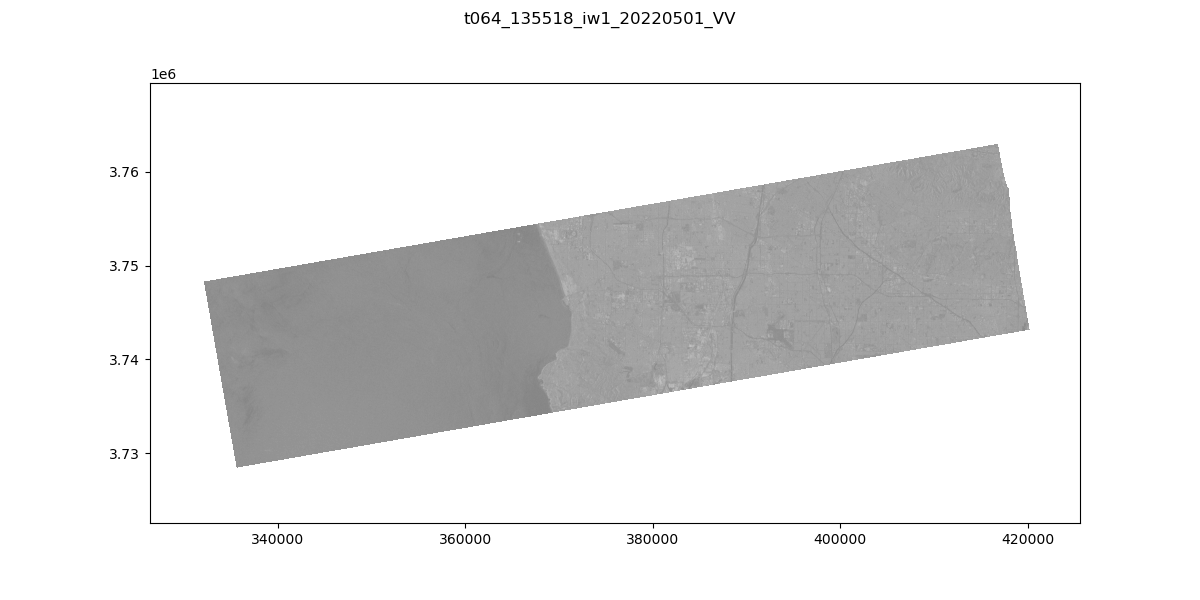

In [4]:
# Visualize CSLC
%matplotlib widget
bbox = [xcoor.min(),xcoor.max(),ycoor.min(),ycoor.max()]
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(20*np.log10(np.abs(cslc)), cmap='gray',interpolation=None, extent=bbox)
fig.suptitle(f'{burst_id}_{date}_{pol}')
ax.set_aspect(1)
fig.savefig('cslc.png',dpi=300,bbox_inches='tight')

# 1. Load and resample the correction layers

In [5]:
corrections_path = f'{DATA_ROOT}/CSLC/corrections'
with h5py.File(path_h5,'r') as h5:
    if orbit_direction == 'Ascending':
        az_fm_mismatch_ = np.flipud(h5[f'{corrections_path}/azimuth_fm_rate_mismatch'][:])
        bistatic_ = np.flipud(h5[f'{corrections_path}/bistatic_delay'][:])
        doppler_shift_ = np.flipud(h5[f'{corrections_path}/geometry_steering_doppler'][:])
    elif orbit_direction == 'Descending':
        az_fm_mismatch_ = np.fliplr(h5[f'{corrections_path}/azimuth_fm_rate_mismatch'][:])
        bistatic_ = np.fliplr(h5[f'{corrections_path}/bistatic_delay'][:])
        doppler_shift_ = np.fliplr(h5[f'{corrections_path}/geometry_steering_doppler'][:])

Correction layer shape: (4698, 19836)
CSLC shape: (4698, 19836)


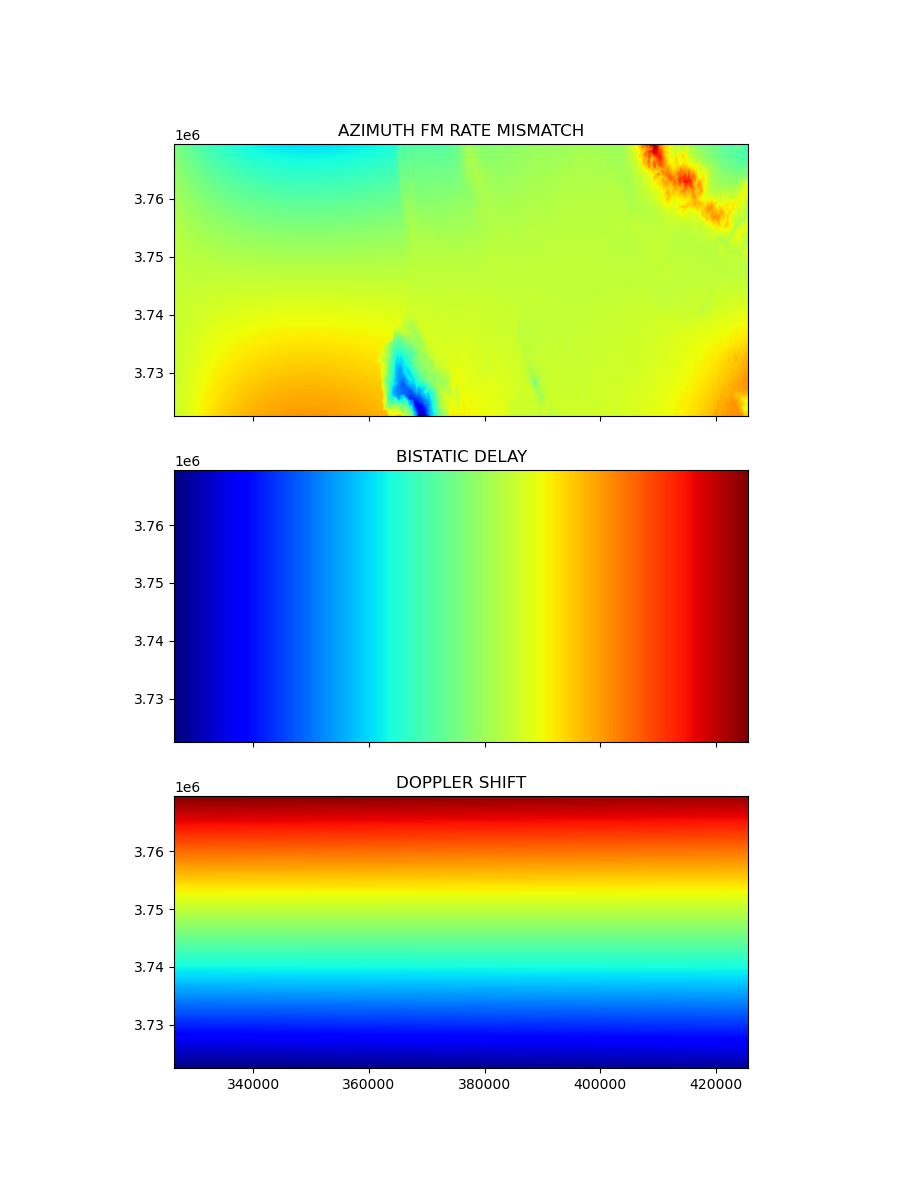

In [6]:
# Interpolate Correction Layers
az_fm_mismatch = interpolate_correction_layers(xcoor, ycoor, az_fm_mismatch_, 'linear')
bistatic = interpolate_correction_layers(xcoor, ycoor, bistatic_, 'linear')
doppler_shift = interpolate_correction_layers(xcoor, ycoor, doppler_shift_, 'linear')

# Visualize Interpolated Correction Layers
%matplotlib widget
fig, ax = plt.subplots(3,1,figsize=(9, 12), sharex=True, sharey=True)
ax[0].imshow(az_fm_mismatch, cmap='jet',interpolation='None', extent=bbox)
ax[0].set_title(f'AZIMUTH FM RATE MISMATCH')
ax[1].imshow(bistatic, cmap='jet',interpolation='None', extent=bbox)
ax[1].set_title(f'BISTATIC DELAY')
ax[2].imshow(doppler_shift, cmap='jet',interpolation='None', extent=bbox)
ax[2].set_title(f'DOPPLER SHIFT')
fig.savefig('correctionLayers.png',dpi=300,bbox_inches='tight')

print(f'Correction layer shape: {bistatic.shape}')
print(f'CSLC shape: {cslc.shape}')


# 2. Get corner reflectors data

In [7]:
# Get the cslc date
date_ = dt.datetime.strptime(sensing_start.astype(str),'%Y-%m-%d %H:%M:%S.%f').strftime('%Y-%m-%d+%H\u0021%M')

# Download corner reflector data from NISAR based on the date of the CSLC product
res = requests.get(f'https://uavsar.jpl.nasa.gov/cgi-bin/corner-reflectors.pl?date={str(date_)}&project=uavsar')
open('crdata.csv', 'wb').write(res.content)

# Read to pandas dataframe and rename columns
df = pd.read_csv('crdata.csv')
df.rename(columns={'Corner reflector ID':'ID'}, inplace=True)
df.rename(columns={'Latitude (deg)':'lat'}, inplace=True) 
df.rename(columns={'Longitude (deg)':'lon'}, inplace=True) 
df.rename(columns={'Azimuth (deg)':'azm'}, inplace=True)
df.rename(columns={'Tilt / Elevation angle (deg)':'tilt'}, inplace=True)
df.rename(columns={'Height above ellipsoid (m)':'hgt'}, inplace=True) 
df.rename(columns={'Side length (m)':'slen'}, inplace=True)

df.head()

,ID,lat,lon,hgt,azm,tilt,slen
0,0,34.796969,-118.096530,660.7979,171.0,11.5,2.4384
1,2,34.805237,-118.087389,660.8081,170.5,8.5,2.4384
2,3,34.805338,-118.081944,661.0041,170.0,7.3,2.4384
3,4,34.805415,-118.076378,661.1669,176.0,12.2,2.4384
4,5,34.805494,-118.070803,661.2366,170.0,10.8,2.4384


In [8]:
#calculating the locations of CRs in SAR image
import shapely.wkt
from shapely import geometry

poly = shapely.wkt.loads(bounding_polygon)

UTMx = []
UTMy = []
xloc = []
yloc = []
xloc_float = []
yloc_float = []
_in = []

for idx, row in df.iterrows():
    
    _Proj = Proj(CRS.from_epsg(epsg_no))
    _x, _y = _Proj(row['lon'], row['lat'],inverse=False)     #conversion of lat/lon of CRs to UTM coordinates
    
    #location of CRs in SLC image
    _xloc = int((_x-xcoor[0])/dx)    
    _yloc = int((_y-ycoor[0])/dy)
    
    UTMx.append(_x) 
    UTMy.append(_y)
    xloc.append(_xloc)
    yloc.append(_yloc)
    xloc_float.append((_x-xcoor[0])/dx)
    yloc_float.append((_y-ycoor[0])/dy)
    _in.append(poly.contains(geometry.Point(_x, _y)))
    
df['UTMx'] = UTMx
df['UTMy'] = UTMy
df['xloc'] = xloc
df['yloc'] = yloc
df['xloc_float'] = xloc_float
df['yloc_float'] = yloc_float
df['inPoly'] = _in

#checking whether CRs are in SLC coverage. Including only CRs within SLC image
df = df[df['inPoly']==True]
df.drop('inPoly', axis=1, inplace=True)
df = df.reset_index(drop=True)
df.head()

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,yloc,xloc_float,yloc_float
